## Test for eth norm factor

input is good  
modify check bal  
modify output graphs and other stuff

In [1]:
!source /etc/profile

import os
import sys
import random
import time
from collections import deque
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Activation, Flatten, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import json
import joblib

# Check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.config.list_physical_devices()

Num GPUs Available:  1


2022-02-09 21:11:13.859396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 21:11:13.971718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 21:11:13.972401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
SEQ_LEN = 48 #hours
FUTURE_PERIOD_PREDICT = 1 #hours

csv_file = "data/formatted/ETHUSDT-1h-data.csv"
model_path = "models/TANH2-e20-b16-s48-fpp1-1644296777-e18-vacc0.002-1644296977.model"
scaler_path = "scalers/" + "-".join(model_path.split("/")[1].split("-")[:6]) + "/"

In [3]:
## Import data
# DATA MUST BE FORMATTED USING CSV_FORMATTER.IPYNB



data_orig = pd.read_csv(csv_file, skiprows=[0], names=["timestamp", "open", "high", "low", "close", "volume", "rsi", "ema"])

# data_orig.set_index("timestamp", inplace=True)

data_orig.head()

,timestamp,open,high,low,close,volume,rsi,ema
0,1503064800,304.73,311.06,304.73,308.88,332.56430,56.653853,305.268933
1,1503068400,308.88,311.79,306.27,307.78,261.15170,55.497845,305.393589
2,1503072000,307.78,310.29,305.73,308.47,388.17208,56.079385,305.543699
3,1503075600,307.17,309.66,301.30,303.22,357.19041,50.849211,305.432161
4,1503079200,303.22,303.22,296.32,298.52,398.64644,46.806430,305.105516


In [4]:
data = pd.DataFrame()

for col in data_orig.columns:
    data[col] = []

data["timestamp"] = data_orig["timestamp"]

data.set_index("timestamp", inplace=True)
data_orig.set_index("timestamp", inplace=True)


# data.head()

for col in ["open", "high", "low", "close", "ema"]:
    data[col] = [x*15 for x in data_orig[col].tolist()]

data["volume"] = [x*.15 for x in data_orig["volume"].tolist()]

data["rsi"] = data_orig["rsi"].tolist()

data.head()

,open,high,low,close,volume,rsi,ema
timestamp,,,,,,,
1503064800,4570.95,4665.90,4570.95,4633.20,49.884645,56.653853,4579.033995
1503068400,4633.20,4676.85,4594.05,4616.70,39.172755,55.497845,4580.903828
1503072000,4616.70,4654.35,4585.95,4627.05,58.225812,56.079385,4583.155492
1503075600,4607.55,4644.90,4519.50,4548.30,53.578561,50.849211,4581.482413
1503079200,4548.30,4548.30,4444.80,4477.80,59.796966,46.806430,4576.582744


In [5]:
## Formatting data

# def classify(current, future):
#     return float((future - current) / current)


# data["future"] = data["close"].shift(-FUTURE_PERIOD_PREDICT)

# Cut off NaNs
# data = data[:-FUTURE_PERIOD_PREDICT]
data.dropna(inplace=True)

# data["target"] = list(map(classify, data["close"], data["future"]))
# data[["close", "future", "target"]].tail()
# data = data.drop("future", 1)


## Load scalers
price_scaler = joblib.load(os.path.join(scaler_path, "price_scaler"))
volume_scaler = joblib.load(os.path.join(scaler_path, "volume_scaler"))
rsi_scaler = joblib.load(os.path.join(scaler_path, "rsi_scaler"))


# Split dataset
# last_5_pct = int(len(data) * .95)

# train_data = data[:last_5_pct]
# validation_data = data[last_5_pct:]

# print(f"{len(train_data)} :: {len(validation_data)}")

data.head()

,open,high,low,close,volume,rsi,ema
timestamp,,,,,,,
1503064800,4570.95,4665.90,4570.95,4633.20,49.884645,56.653853,4579.033995
1503068400,4633.20,4676.85,4594.05,4616.70,39.172755,55.497845,4580.903828
1503072000,4616.70,4654.35,4585.95,4627.05,58.225812,56.079385,4583.155492
1503075600,4607.55,4644.90,4519.50,4548.30,53.578561,50.849211,4581.482413
1503079200,4548.30,4548.30,4444.80,4477.80,59.796966,46.806430,4576.582744


In [6]:
## Preprocess Data

def preprocess_df(df_p):

    df = pd.DataFrame()
    for col in df_p.columns:
        df[col] = df_p[col]

    for col in df.columns:
        scaler = None
        if col in ["open", "high", "low", "close", "ema", "target"]:
            scaler = price_scaler
        elif col == "volume":
            scaler = volume_scaler
        elif col == "rsi":
            scaler = rsi_scaler
        else:
            raise Exception("Column not recognized and scaler cannot be determined")

        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        df[col] = scaler.transform(np.array(df[col]).reshape(-1, 1))


    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    sequential_data = []
    prev_periods = deque(maxlen=SEQ_LEN)

    for i in df.values:
        prev_periods.append([n for n in i])
        if len(prev_periods) == SEQ_LEN:
            sequential_data.append([np.array(prev_periods), i])

    # random.shuffle(sequential_data)

    # # Balance buys and sells
    # buys = []
    # sells = []

    # for seq, target in sequential_data:

    #     if target < 0.0:
    #         sells.append([seq, target])
    #     elif target > 0.0:
    #         buys.append([seq, target])

    # lower = min(len(buys), len(sells))

    # buys = buys[:lower]
    # sells = sells[:lower]

    # sequential_data = buys + sells

    # random.shuffle(sequential_data)

    X = [d[0] for d in sequential_data]
    # Y = [d[1] for d in sequential_data]

    # return np.array(X), np.array(Y)
    return np.array(X)
    
    
seq_data = preprocess_df(data)

In [7]:
## Load model

model = load_model(model_path)
model.summary()


2022-02-09 21:11:20.996758: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-09 21:11:20.998291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 21:11:20.999030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 21:11:20.999633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 128)           69632     
                                                                 
 dropout (Dropout)           (None, 48, 128)           0         
                                                                 
 batch_normalization (BatchN  (None, 48, 128)          512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 48, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 48, 128)           0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 128)          512       
 hNormalization)                                        

In [7]:
bal = 10000
usd_bal = 10000
coin_bal = 0

price = 234890

list(data["close"])[0+24]

# print(f"BAL {bal}\tUSD {usd_bal}\tCOIN {coin_bal}")

4000.58

In [8]:
with tf.device("/device:GPU:0"):
    pred = model.predict(seq_data)

    # print(json.dumps([float(list(d)[0]) for d in list(model.predict(seq_data))], indent=4))
    

pred

2022-02-09 21:11:30.446471: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


array([[-0.89330995],
       [-0.89321464],
       [-0.8932492 ],
       ...,
       [-0.04228877],
       [-0.04480282],
       [-0.04063271]], dtype=float32)

-0.8994304537773132

In [9]:
unscaled_pred = price_scaler.inverse_transform(pred)
len(unscaled_pred)

38555

In [49]:
# get_price(38600)
# list(data["close"])[38648]
len(data["close"]) - 47
# len(seq_data)

38581

In [14]:
bal = 10000.0
usd_bal = bal
coin_bal = 0.0

In [18]:
bal

9950.0

In [12]:
import math
joined = list(zip([x[0]/15 for x in unscaled_pred.tolist()[lim:]], [x/15 for x in data["close"].to_list()[47+lim:]]))

se = 0

for p in joined:
    se += math.sqrt((p[0] - p[1])**2)

mse = se / len(joined)
mse

65.33157240426209

In [21]:
d1 = np.array([x[0]/15 for x in unscaled_pred.tolist()[lim:]])
d2 = np.array([x/15 for x in data["close"].to_list()[47+lim:]])

mse = np.sqrt(np.sum((d1-d2)**2))
mse

15537.772165654642

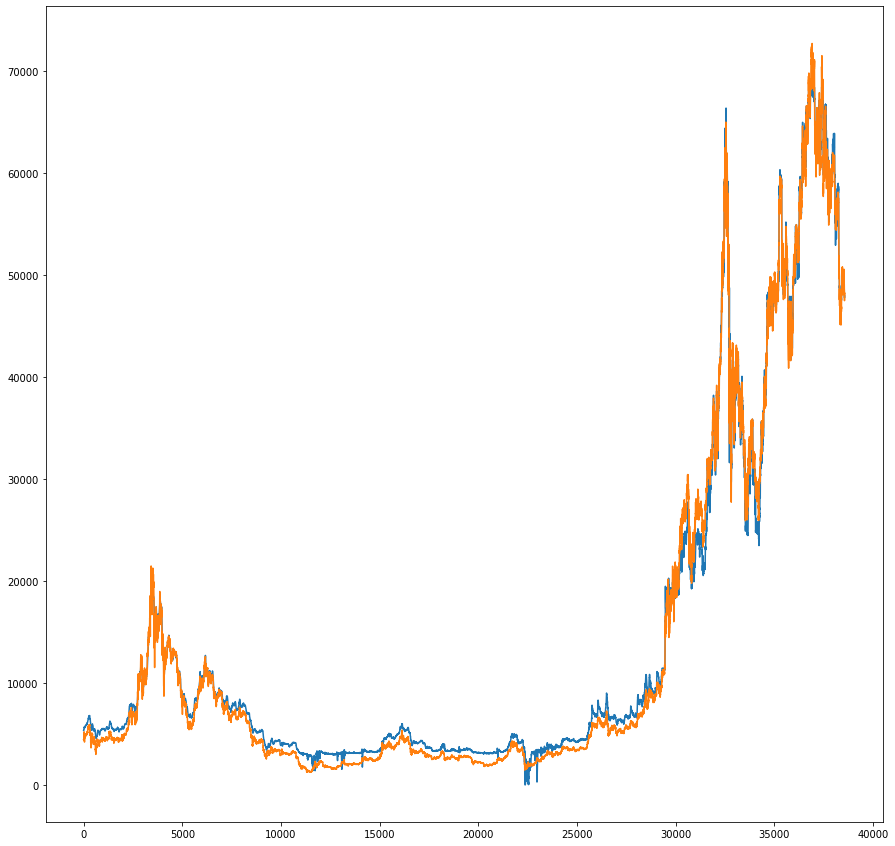

In [11]:
plt.rcParams["figure.figsize"] = (15,15)

x = list(range(len(unscaled_pred)))
lim = 0

plt.plot(x, unscaled_pred.tolist()[lim:], label="pred")
plt.plot(x, data["close"][47+lim:], label="real")
plt.show()

In [13]:
scaler = joblib.load(scaler_path)
unscaled_pred = scaler.inverse_transform(pred)
print(json.dumps([float(list(d)[0]) for d in list(unscaled_pred)], indent=4))

[
    -0.00026289792731404305,
    -0.00026227114722132683,
    -0.00032883943640626967,
    -0.0007795246783643961,
    -0.0003816113749053329,
    -0.00033874859218485653,
    -0.0002698771422728896,
    -0.0002294909063493833,
    -0.0001965714036487043,
    -0.00013605270942207426,
    -0.00020051244064234197,
    -0.0002557127154432237,
    -0.00025334511883556843,
    -0.00025561705115251243,
    -0.0002571223594713956,
    -0.00025868392549455166,
    -0.00026816027821041644,
    -0.0003238792414776981,
    -0.00038896629121154547,
    -0.00026311088004149497,
    -0.0002467295271344483,
    -0.00021753960754722357,
    -0.00022326872567646205,
    -0.00022712985810358077,
    -0.0002517332904972136,
    -0.00026581002748571336,
    -0.0002652929397299886,
    -0.0002636118442751467,
    -0.000262381014181301,
    -0.0002676204312592745,
    -0.0004021658096462488,
    -0.00036329770227894187,
    -0.0002789665013551712,
    -0.00024703878443688154,
    -0.00022568357235286385,


In [17]:
## Trading bot (test only)

start_seq = 0

islong = True

json_msgs = []

# bal = 10000.0
# usd_bal = bal
# coin_bal = 0.0

bal = float(list(data_orig["close"])[SEQ_LEN-1])
usd_bal = float(list(data_orig["close"])[SEQ_LEN-1])
coin_bal = 1.0



model_trade_x = list(range(start_seq, len(seq_data) + 1))
model_trade_y = []

def do_buy(price):
    global usd_bal
    global coin_bal
    global islong

    if usd_bal == 0:
        return

    islong = True

    usd_bal -= usd_bal * calc_fee()
    coin_bal += (usd_bal / price)
    usd_bal = 0

    calc_bal(price)

def do_sell(price):
    global usd_bal
    global coin_bal
    global islong

    if coin_bal == 0:
        return

    islong = False

    usd_bal += (coin_bal * price)
    usd_bal -= usd_bal * calc_fee()
    coin_bal = 0

    calc_bal(price)

def calc_bal(price):
    global bal
    bal = usd_bal + (coin_bal * price)

def calc_fee():
    # return 0
    if bal > 1000000:
        return .0018
    elif bal > 100000:
        return .0020
    elif bal > 50000:
        return .0025
    elif bal > 10000:
        return .0035
    else:
        return .0050

def get_price(i):
    return float(list(data["close"])[i+SEQ_LEN-1])

def get_price_real(i):
    return float(list(data_orig["close"])[i+SEQ_LEN-1])

def predict(seq):
    with tf.device("/device:GPU:0"):
        return model.predict(seq)[0]

def full_predict(full_seq):
    with tf.device("/device:GPU:0"):
        return model.predict(full_seq)


def main_loop_iter():
    print(f"ITER LEN: {len(seq_data)}")

    for i in range(start_seq, len(seq_data)):
        print(f"SEQ: {i}\tBAL: {bal}")
        model_trade_y.append(bal)
        prediction = predict(seq_data[i:i+1])

        if prediction[0] > prediction[1]:
            do_buy(get_price(i))
        else:
            do_sell(get_price(i))
        

    do_sell(get_price(len(seq_data)-1))
    model_trade_y.append(bal)
    print(f"FINAL BAL: {bal}")

def main_loop():
    global bal
    print(f"ITER LEN: {len(seq_data)}")

    raw_prediction = full_predict(seq_data)
    prediction = price_scaler.inverse_transform(raw_prediction)
    pct_change = 0.0

    # pred_pct_change_list = []

    for i in range(start_seq, len(seq_data)):
        calc_bal(get_price_real(i))
        msg = "SEQ: {i}\tBAL: {bal}\t%DELTA: {pct_change}\tPOSITION: {'LONG' if islong else 'SHORT'}"
        # print(msg)
        json_msgs.append(msg)

        model_trade_y.append(bal)

        if i == 0: continue

        if i % 1000 == 0:
            print(f"SEQ {i}")

        pred_price = float(prediction[i])

        # if prediction[i][0] > .8 and prediction[i][1] < .2:
        #     do_buy(get_price(i))
        # if prediction[i][1] > .8 and prediction[i][0] < .2:
        #     do_sell(get_price(i))
        # else:
        #     pass

        pct_change = float((pred_price - get_price(i)) / get_price(i))
        # print(f"Pred: {pred_price}\tPrice: {get_price(i)}")

        # pred_pct_change_list.append(pct_change)

        if pct_change > 0.01:
            do_buy(get_price_real(i))
        elif pct_change < -0.01:
            do_sell(get_price_real(i))
            
        

    do_sell(get_price_real(len(seq_data)-1-SEQ_LEN))
    model_trade_y.append(bal)
    print(f"FINAL BAL: {bal}")


main_loop()

ITER LEN: 38555
SEQ 1000
SEQ 2000
SEQ 3000
SEQ 4000
SEQ 5000
SEQ 6000
SEQ 7000
SEQ 8000
SEQ 9000
SEQ 10000
SEQ 11000
SEQ 12000
SEQ 13000
SEQ 14000
SEQ 15000
SEQ 16000
SEQ 17000
SEQ 18000
SEQ 19000
SEQ 20000
SEQ 21000
SEQ 22000
SEQ 23000
SEQ 24000
SEQ 25000
SEQ 26000
SEQ 27000
SEQ 28000
SEQ 29000
SEQ 30000
SEQ 31000
SEQ 32000
SEQ 33000
SEQ 34000
SEQ 35000
SEQ 36000
SEQ 37000
SEQ 38000
FINAL BAL: 1087.0314949053889


In [18]:
from pushbullet import Pushbullet
pb = Pushbullet("o.nyntgspLep97yl0oPDbp0nAbMIDUGiO5")
push = pb.push_note(f"{time.asctime()}", "ML Eval Done")

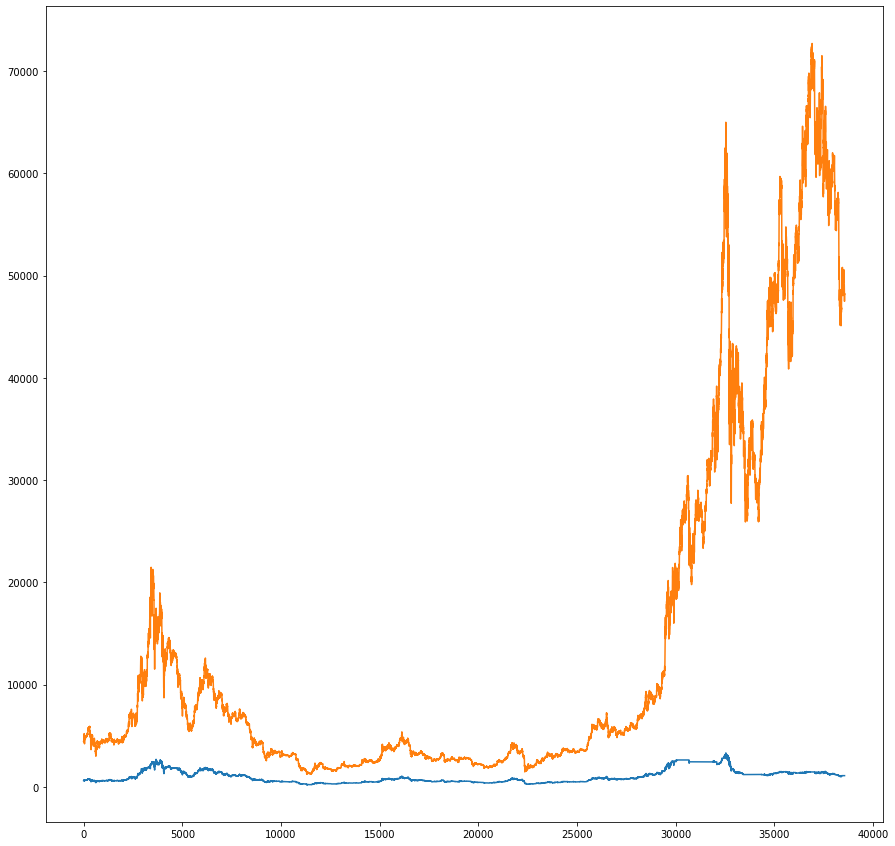

In [19]:
plt.rcParams["figure.figsize"] = (15,15)
plt.plot(model_trade_x, model_trade_y)
plt.plot(model_trade_x, data["close"].tail(len(seq_data)+1))

In [16]:
data_orig.tail()

,open,high,low,close,volume,rsi,ema
timestamp,,,,,,,
1642464000,3216.70,3226.04,3212.94,3218.96,6471.5899,39.456816,3291.323954
1642467600,3218.79,3224.24,3207.38,3208.35,5793.2246,38.266958,3288.647375
1642471200,3208.35,3210.54,3152.09,3165.32,15766.2425,33.969239,3284.669073
1642474800,3165.33,3216.27,3141.10,3192.57,15348.3694,38.494528,3281.698135
1642478400,3192.58,3221.00,3191.43,3211.36,8010.7869,41.361141,3279.429163
